The data is available as two attached CSV files:
takehome_user_engagement. csv
takehome_users . csv

Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven day period, identify which factors predict future user adoption.

_____________

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

Let's read data from "takehome_user_engagement.csv" file and check what's inside:

In [2]:
engagement = pd.read_csv("takehome_user_engagement.csv", na_values="NaN")

In [3]:
engagement.shape

(207917, 3)

In [4]:
engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
len(engagement['user_id'].unique())

8823

We have 8823 unique users who actually has logged into the product at least once.

In [6]:
#converting 'time_stamp' to datetime format:
engagement['time_stamp'] = pd.to_datetime(engagement['time_stamp'])

In [7]:
#'visited' column doesn't provide additional information
engagement.drop(['visited'], axis = 1, inplace = True)

In order to find adopted users, let's calculate number of visits per 7 days rolling window for each user:

In [8]:
#number of visits per 7 days rolling window for each user:
logs_per_week = engagement.groupby('user_id').rolling('7D', on='time_stamp', min_periods = 3).count()

In [9]:
#filtering users with more than 3 logs per week:
adopted = logs_per_week[logs_per_week.user_id >= 3].index.get_level_values('user_id').unique().values

In [10]:
len(adopted)

1602

As we can see, there are 1602 adopted users. 

_________________

Now let's read data from 'takehome_users.csv':

In [11]:
df = pd.read_csv("takehome_users.csv", encoding='latin-1', index_col = 'object_id', na_values="NaN")

In [12]:
df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [13]:
len(df)

12000

So we have 12000 users, but only 8823 of them actually logged in.

In [14]:
#adding column with indicator if user is adopted:
df['adopted'] = df.apply(lambda row: row.name in adopted, axis=1)

Now let's change columns types accordingly: 

In [15]:
df["creation_time"] = np.int64(pd.to_datetime(df["creation_time"]))
df["last_session_creation_time"] = np.int64(pd.to_datetime(df["last_session_creation_time"], unit='s'))
df["creation_source"] = df["creation_source"].astype("category")
df["org_id"] = df["org_id"].astype("category")
df["invited_by_user_id"] = df["invited_by_user_id"].astype("category")
df["opted_in_to_mailing_list"] = df["opted_in_to_mailing_list"].astype("category")
df["enabled_for_marketing_drip"] = df["enabled_for_marketing_drip"].astype("category")
df["creation_source"] = df["creation_source"].astype("category")

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 10 columns):
creation_time                 12000 non-null int64
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null category
last_session_creation_time    12000 non-null int64
opted_in_to_mailing_list      12000 non-null category
enabled_for_marketing_drip    12000 non-null category
org_id                        12000 non-null category
invited_by_user_id            6417 non-null category
adopted                       12000 non-null bool
dtypes: bool(1), category(5), int64(2), object(2)
memory usage: 686.2+ KB


_____________________

To investigate which factors predict future user adoption, let's create a predictive model and go from there. Tree based models are easy to interpret in terms of variables importance, so let's see if a gradient boosting tree based method will work in our case. 

In [17]:
#Spliting data to predictors and target variabe:
X = df.drop(columns=['name', 'email', 'adopted'])
y = df['adopted']

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
import lightgbm as lgb
from lightgbm import LGBMClassifier

#splitting to train and validation datasets:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

#defining the model parameters:
model = LGBMClassifier(
    boosting_type="gbdt",
    n_estimators=200,
    learning_rate=0.01,
    subsample=0.8,
    n_jobs=8,
)

Cross-validation will help our certainty about variable importance - that it's not just the property of particular run:

In [19]:
#fitting cross-validated model
model_cv = cross_validate(
    estimator = model,
    X = X_train,
    y=y_train,
    cv = 5,
    n_jobs=8,
    return_estimator=True,
)

In [20]:
#accessing the validation score:
model_cv['test_score']

array([0.96966092, 0.97560976, 0.97321429, 0.97260274, 0.96902918])

In [21]:
np.mean(model_cv['test_score'])

0.9720233763394696

Mean test score is 0.97, which is pretty decent score to allow us to proceed with feature importance interpretation. 

In [22]:
#building feature_importance array
feature_importance = [
    model_cv["estimator"][i].feature_importances_
    for i in range(0, len(model_cv["estimator"]))
]
feature_importance = pd.DataFrame(data=feature_importance, columns=X.columns)
feature_importance = feature_importance.reindex(
    feature_importance.mean().sort_values(ascending=False).index, axis=1
)

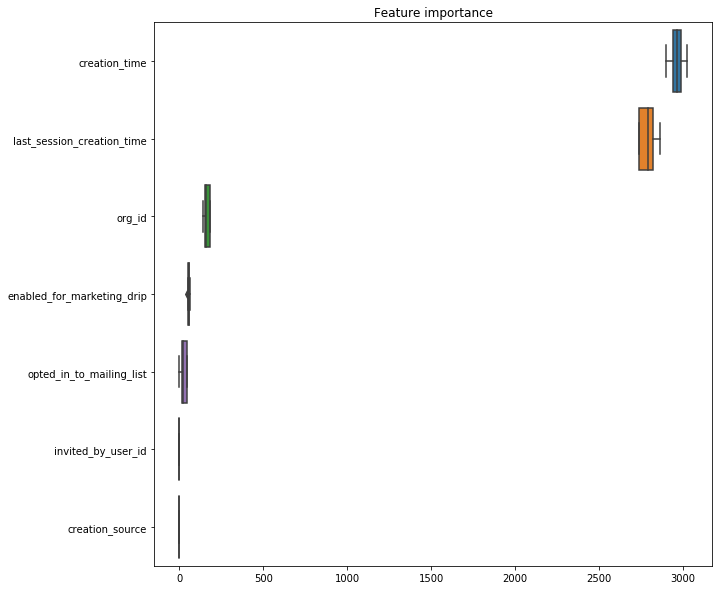

In [23]:
#plotting feature_importance plot
plt.figure(figsize=(10, 10))
sns.boxplot(data=feature_importance, orient="h")
plt.title("Feature importance")
plt.show()

As we can see from the plot, by far the most important are variables 'creation_time' and 'last_session_creation_time'. The least important are 'invited_by_user_id' and 'creation_source'.
Let's take a look at the most important ones:

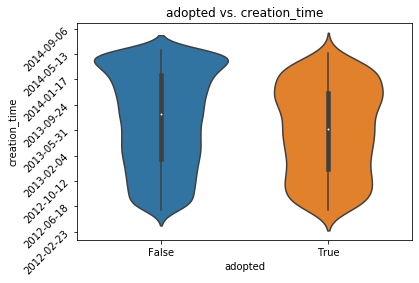

In [24]:
#building violin plot for creation_time
sns.violinplot(
    x="adopted",
    y="creation_time",
    data=df,
)
plt.title("adopted vs. creation_time")

# get current axis
ax = plt.gca()
# get current ytick labels
yticks = ax.get_yticks()
#convert all ytick labels to selected format from ms timestamp
ax.set_yticklabels([pd.to_datetime(tm).strftime('%Y-%m-%d') for tm in yticks],rotation=45)

plt.show()

The adopted vs. creation_time plot shows us that adopted users profiles tend to be created earlier than non adopted ones. The first peak of adopted users creation is around August 2012, the second - around January 2014.
The later a profile was created - the more not adopted users there are. Particularly lot of them have been created around April 2014. 

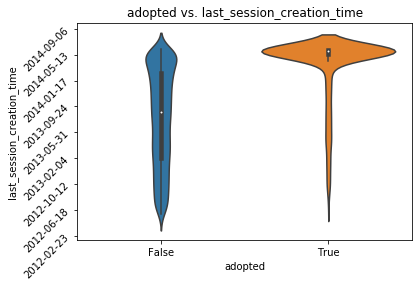

In [27]:
sns.violinplot(
    x="adopted",
    y="last_session_creation_time",
    #filtering out users who never actually logged in
    data=df[df.last_session_creation_time>0]
)
plt.title("adopted vs. last_session_creation_time")

# get current axis
ax = plt.gca()
# get current ytick labels
yticks = ax.get_yticks()
#convert all ytick labels to selected format from ms timestamp
ax.set_yticklabels([pd.to_datetime(tm).strftime('%Y-%m-%d') for tm in yticks],rotation=45)

plt.show()

As we can see from adopted vs. last_session_creation_time plot, adopted users are predictably keep visiting our product - they are active in recent time frame.